In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd

/Users/preeyakhanna


In [4]:
cd bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [6]:
import pickle

In [35]:
import analysis_config
from online_analysis import generate_models_utils, util_fcns

In [16]:
####### dictionary for saving out null models 
null_models = {}

### model name: predict next neural activity | current neural actiivty 
model_nm = 'hist_1pos_0psh_0spksm_1_spksp_0'

### first fold of test/train 
i_fold = 0; 

### Not a task specific model 
type_of_model = 0;

### Loop through animals 
for i_a, animal in enumerate(['grom', 'jeev']): 
    
    ### Open up trained null models (with optimized alphas): 
    NULL_dict = pickle.load(open(os.path.join(analysis_config.config['%s_pref'%animal], 'tuning_models_%s_model_set6__null_alpha.pkl'%animal), 'rb'))
                
    ### Loop through days 
    for i_d in range(analysis_config.data_params['%s_ndays'%animal]): 
        
        ### Get model 
        model = NULL_dict[i_d, model_nm, i_fold, type_of_model, 'model']
        
        # Model inputs: spike-counts, output: spike-counts (multiply by 10 to get in Hz)
        null_models[animal, i_d] = model; 

### save out models to null_dynamics_models in shared folder: 
path = '/Users/preeyakhanna/Dropbox/Carmena_Lab/Documentation/BMI_co_obs_paper/data/null_dynamics_models'
pickle.dump(null_models, open(os.path.join(path, 'null_dynamics_models.pkl'), 'wb'))
        

((64,), (64,), (18, 44), 6, (18,))
[0. 1. 2. 3. 4. 5. 6. 7.]
((64,), (64,), (18, 44), 6, (18,))
[0. 1. 2. 3. 4. 5. 6. 7.]
((64,), (64,), (18, 44), 6, (18,))
[0. 1. 2. 3. 4. 5. 6. 7.]
new trial offset 64, total trls in this blk 64
((101,), (101,), (40, 44), 6, (40,))
[0. 1. 2. 3. 4. 5. 6. 7.]
((101,), (101,), (40, 44), 6, (40,))
[0. 1. 2. 3. 4. 5. 6. 7.]
((101,), (101,), (40, 44), 6, (40,))
[0. 1. 2. 3. 4. 5. 6. 7.]
new trial offset 165, total trls in this blk 101
((122,), (122,), (97, 44), 6, (97,))
[0. 1. 2. 3. 4. 5. 6. 7.]
((122,), (122,), (97, 44), 6, (97,))
[0. 1. 2. 3. 4. 5. 6. 7.]
((122,), (122,), (97, 44), 6, (97,))
[0. 1. 2. 3. 4. 5. 6. 7.]
new trial offset 287, total trls in this blk 122
Animal grom, tsk 0, N = 2229
Tsk 0, Trg 0.00, N = 258
Tsk 0, Trg 1.00, N = 337
Tsk 0, Trg 2.00, N = 319
Tsk 0, Trg 3.00, N = 321
Tsk 0, Trg 4.00, N = 308
Tsk 0, Trg 5.00, N = 271
Tsk 0, Trg 6.00, N = 189
Tsk 0, Trg 7.00, N = 226
Animal grom, tsk 1, N = 9168
Tsk 1, Trg 0.10, N = 1028
Tsk 1, Trg

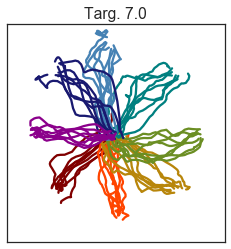

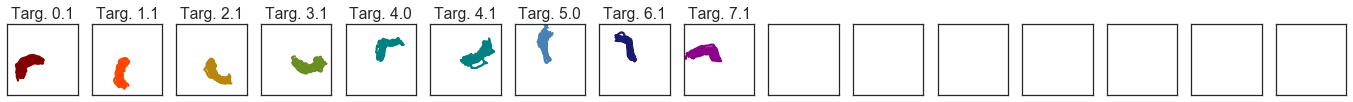

In [26]:
### using model to predict next activity 
### example: grom, 0; 
animal = 'grom'; 
i_d = 0; 

### inputs needed to pull spiking data: 
order_d = analysis_config.data_params['%s_ordered_input_type'%animal][i_d]
day = analysis_config.data_params['%s_input_type'%animal][i_d]
history_bins_max = 1; 
within_bin_shuffle = False; 
keep_bin_spk_zsc = False; 
null_pred = False; 

data, data_temp, sub_spikes, sub_spk_temp_all, sub_push_all = generate_models_utils.get_spike_kinematics(animal, day, 
    order_d, history_bins_max, within_bin_shuffle = within_bin_shuffle, keep_bin_spk_zsc = keep_bin_spk_zsc,
    day_ix = i_d, null = null_pred)

In [48]:
### Kalman gain (2 x NNeurons)
KG  = util_fcns.get_decoder(animal, i_d)

In [51]:
### Sub-spikes is full spike counts (T x NNeurons) -- just double check 
assert(np.allclose(sub_push_all, np.dot(KG, sub_spikes.T).T))

In [52]:
### Get out the right null model: 
model =  null_models[animal, i_d]

## Ridge Model 
## A matrix: model.coef_, 
## b vector: model.intercept_
pred = np.mat(model.coef_)*np.mat(sub_spikes.T) + model.intercept_[:, np.newaxis]

### usual way of doing model predictions with sklearn models; 
pred_ = model.predict(sub_spikes).T

### check these are the same 
assert(np.allclose(pred, pred_))

In [54]:
## Verify predictions are null: 
pot = np.dot(KG, pred) # 2 x T; 
assert(np.allclose(np.linalg.norm(pot, axis=0), 0)) # norm of neural push (dim 0)